# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### Questions:

1. When is the month where the most new members join?
2. What is the average age of the members completing offers? Also, if we look at the distribution of ages, is there a specific age range that is more willing to complete offers?
3. What is the income distribution like for the members who completed BOGO offers and/or Discount offers?

In [1]:
import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from random import *
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
# The big thing I would like to change about the portfolio dataframe is
# to separate the channels to its own columns

unique_channels_dummy = []
unique_channels = ['web', 'email', 'mobile', 'social']
web = 0
email = 1
mobile = 2
social = 3

for _, curr_row in portfolio.iterrows():
    row_dummy = [0,0,0,0]
    for channel in curr_row['channels']:
        if channel[0] == 'w':
            row_dummy[web] = 1
        if channel[0] == 'e':
            row_dummy[email] = 1
        if channel[0] == 'm':
            row_dummy[mobile] = 1
        if channel[0] == 's':
            row_dummy[social] = 1
    unique_channels_dummy.append(row_dummy)
    
portfolio = pd.concat([portfolio, pd.DataFrame(unique_channels_dummy, columns = unique_channels)], axis = 1)
portfolio.drop(columns = ['channels'], inplace = True)

portfolio

,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


In [4]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [5]:
profile['age'].value_counts().head(10)

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
Name: age, dtype: int64

The problem that sticks out to me the most is the age, we can see there is an age of 118. We are safe to assume those are outliers/bad data, as we see there are an overwhelming number of rows with age = 118

In [6]:
profile[profile['age'] == 118].head(20)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [8]:
profile['gender'].isnull().sum()

2175

Some more issues that we can see here is that the age of 118 seems to always have no gender as well as missing values for the income.

There are several ways of potentially fixing this, such as just outright getting rid of the rows that have missing values or the age 118. **However**, a big problem with this would be that there are so many rows with just even the age of 118, so we could potentially be getting rid of too much of the data.

Thus, the way that I will go about to cleaning this data would be for the **age column**, I will **replace all the 118 values (or other values that are outliers i.e. age > 90) with the median age**. For the missing values in gender, I will replace them with **randomly assigned genders**. Finally, for the missing values in income, I will replace them with the **mean of the incomes** on the respective became_member_on.

**Note: With replacing with the median age, the ages might be biased too heavily**

In [9]:
# Quick side note: let's clean up the became_member_on to a datetime type
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Mean of the incomes on the became_member_on
mean_income = profile.groupby('became_member_on', as_index = False)['income'].mean()

# Median age
median_age = profile['age'].median()


# Replacing the outlier ages with the median age 
# Resource used: https://kanoki.org/2019/07/17/pandas-how-to-replace-values-based-on-conditions/
profile.loc[profile.age > 90, 'age'] = median_age

# Replacing the missing values of income
profile.loc[profile.income.isnull() == True, 'income'] = mean_income


rand_gender = []
for i in range(0, 2175):
    x = randint(0,2)
    rand_gend = 'M'
    if x == 0:
        rand_gend = 'F'
    elif x == 1:
        rand_gend = 'O'
    rand_gender.append(rand_gend)
    
none_counter = 0
for _, curr_row in profile.iterrows():
    if curr_row['gender'] == None:
        profile.loc[profile.gender == None, 'gender'] = rand_gender[none_counter]
        none_counter += 1


profile.head(10)

,age,became_member_on,gender,id,income
0,58.0,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,69000.000000
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,58.0,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,58000.000000
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,58.0,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,77500.000000
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.000000
6,58.0,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,35000.000000
7,58.0,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,72666.666667
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.000000
9,58.0,2016-11-22,None,8974fc5686fe429db53ddde067b88302,86000.000000


In [10]:
# One last thing to do is to separate the month from when users became members
profile['became_member_on_month'] = profile.became_member_on.dt.month

In [11]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


### Question 1: Determine when is the best month/season of users becoming members

In [12]:
profile.head(10)

,age,became_member_on,gender,id,income,became_member_on_month
0,58.0,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,69000.000000,2
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,7
2,58.0,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,58000.000000,7
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,5
4,58.0,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,77500.000000,8
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.000000,4
6,58.0,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,35000.000000,9
7,58.0,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,72666.666667,10
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.000000,2
9,58.0,2016-11-22,None,8974fc5686fe429db53ddde067b88302,86000.000000,11


In [13]:
joined_month = profile.groupby(profile['became_member_on_month'])['id'].count()
joined_month

became_member_on_month
1     1525
2     1202
3     1329
4     1315
5     1307
6     1265
7     1359
8     1610
9     1515
10    1568
11    1449
12    1556
Name: id, dtype: int64

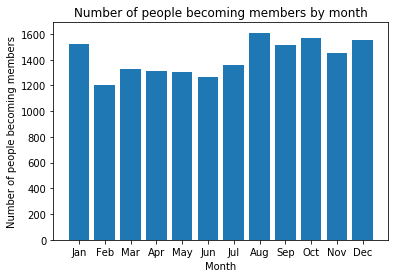

In [14]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_pos = [i for i,_ in enumerate(month)]

plt.bar(month_pos, joined_month)
plt.xticks(month_pos, month)
plt.xlabel('Month')
plt.ylabel('Number of people becoming members')
plt.title('Number of people becoming members by month')
plt.show()

In [15]:
spring = joined_month[3] + joined_month[4] + joined_month[5]
summer = joined_month[6] + joined_month[7] + joined_month[8]
fall = joined_month[9] + joined_month[10] + joined_month[11]
winter = joined_month[12] + joined_month[1] + joined_month[2]

joined_month_seasons = [spring, summer, fall, winter]

season = ['Spring', 'Summer', 'Autumn', 'Winter']
season_pos = [i for i,_ in enumerate(season)]

In [16]:
joined_month_seasons

[3951, 4234, 4532, 4283]

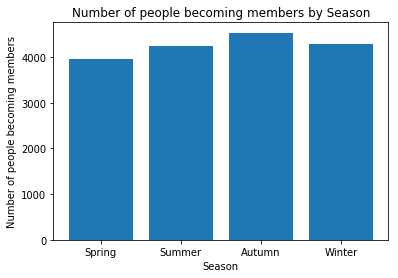

In [17]:
plt.bar(season_pos, joined_month_seasons)
plt.xticks(season_pos, season)
plt.xlabel('Season')
plt.ylabel('Number of people becoming members')
plt.title('Number of people becoming members by Season')
plt.show()

### Question 2: Average age of completing offers vs not


In [18]:
ids_profile = profile['id']
ids_transcript = transcript['person']
ids_present_both = np.intersect1d(ids_profile, ids_transcript)

In [19]:
# for id in ids_present_both:
ids_present_both

array(['0009655768c64bdeb2e877511632db8f',
       '00116118485d4dfda04fdbaba9a87b5c',
       '0011e0d4e6b944f998e987f904e8c1e5', ...,
       'fff8957ea8b240a6b5e634b6ee8eafcf',
       'fffad4f4828548d1b5583907f2e9906b',
       'ffff82501cea40309d5fdd7edcca4a07'], dtype=object)

In [20]:
ids_present_both_completed = []
ids_present_both_non_completed = []

for id in tqdm(ids_present_both):
    if 'offer completed' in list(transcript[transcript['person'] == id]['event']):
        ids_present_both_completed.append(id)
    else:
        ids_present_both_non_completed.append(id)


100%|██████████| 17000/17000 [08:13<00:00, 34.84it/s]


In [21]:
len(ids_present_both_completed)

12774

In [22]:
len(ids_present_both_non_completed)

4226

In [23]:
age_completed = []
age_not_completed = []

for id in tqdm(ids_present_both_completed):
    age_completed.append(int(profile.loc[profile.id == id]['age']))
    
for id in tqdm(ids_present_both_non_completed):
    age_not_completed.append(int(profile.loc[profile.id == id]['age']))

100%|██████████| 4226/4226 [00:10<00:00, 418.48it/s]


In [24]:
avg_age_completed = sum(age_completed) / len(age_completed)
avg_age_not_completed = sum(age_not_completed) / len(age_not_completed)

print("Average age of members who completed at least 1 offer: {}".format(avg_age_completed))
print("Average age of members who did not complete 1 offer: {}".format(avg_age_not_completed))

Average age of members who completed at least 1 offer: 54.89987474557695
Average age of members who did not complete 1 offer: 52.85849503076195


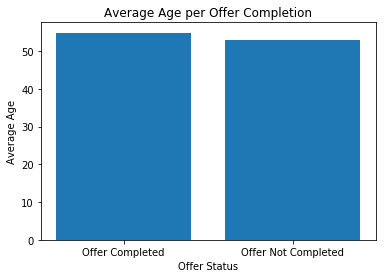

In [25]:
avg_ages = [avg_age_completed, avg_age_not_completed]

offer_status = ['Offer Completed', 'Offer Not Completed']
offer_status_pos = [i for i,_ in enumerate(offer_status)]

plt.bar(offer_status_pos, avg_ages)
plt.xticks(offer_status_pos, offer_status)
plt.xlabel('Offer Status')
plt.ylabel('Average Age')
plt.title('Average Age per Offer Completion')
plt.show()

In [26]:
# Resource used to find this syntax: https://stackoverflow.com/questions/53342715/pandas-dataframe-select-rows-where-a-list-column-contains-any-of-a-list-of-strin
# This is creating a dataframe with only the id's that we're interested in
# (members who completed offers or not)
df_completed = profile[pd.DataFrame(profile.id.tolist()).isin(ids_present_both_completed).any(1)]
df_not_completed = profile[pd.DataFrame(profile.id.tolist()).isin(ids_present_both_non_completed).any(1)]

comp_min_age = df_completed['age'].min()
comp_max_age = df_completed['age'].max()

not_comp_min_age = df_not_completed['age'].min()
not_comp_max_age = df_not_completed['age'].max()


In [27]:
# np.arange resource used: https://realpython.com/how-to-use-numpy-arange/
# Create the distribution of incomes for members who completed bogo and/or discount 

df_completed_dist = df_completed.groupby(pd.cut(df_completed['age'], np.arange(start = comp_min_age, stop = comp_max_age, step = 10)))['id'].count()
df_not_completed_dist = df_not_completed.groupby(pd.cut(df_not_completed['age'], np.arange(start = not_comp_min_age, stop = not_comp_max_age, step = 10)))['id'].count()


In [28]:
df_comp_dist_percentage = df_completed_dist / len(age_completed)

In [29]:
df_not_comp_dist_percentage = df_not_completed_dist / len(age_not_completed)

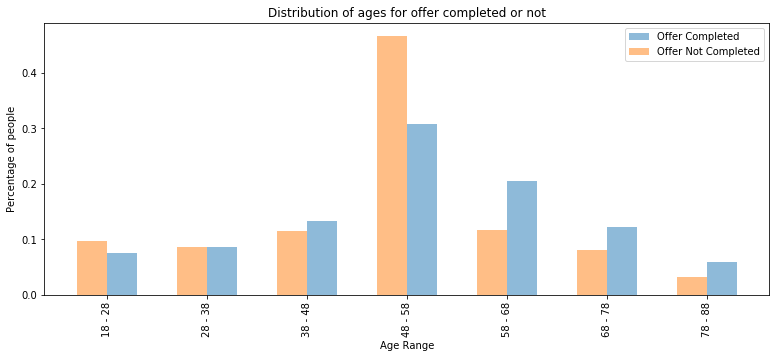

In [30]:
age_bin = ['18 - 28', '28 - 38', '38 - 48' , '48 - 58', '58 - 68' , '68 - 78', '78 - 88']
age_bin_pos = [i for i,_ in enumerate(age_bin)]

plt.figure(figsize = (13, 5))
plt.bar(age_bin, df_comp_dist_percentage, alpha = 0.5, width = 0.3, align = 'edge', label = 'Offer Completed')
plt.bar(age_bin, df_not_comp_dist_percentage, alpha = 0.5, width = -0.3, align = 'edge', label = 'Offer Not Completed')
plt.xticks(age_bin_pos, age_bin, rotation='vertical')
plt.xlabel('Age Range')
plt.ylabel('Percentage of people')
plt.title('Distribution of ages for offer completed or not')
plt.legend()
plt.show()

In [31]:
age_diff = df_comp_dist_percentage - df_not_comp_dist_percentage
age_diff

age
(18.0, 28.0]   -0.021159
(28.0, 38.0]    0.000684
(38.0, 48.0]    0.018088
(48.0, 58.0]   -0.160000
(58.0, 68.0]    0.088369
(68.0, 78.0]    0.041902
(78.0, 88.0]    0.027866
Name: id, dtype: float64

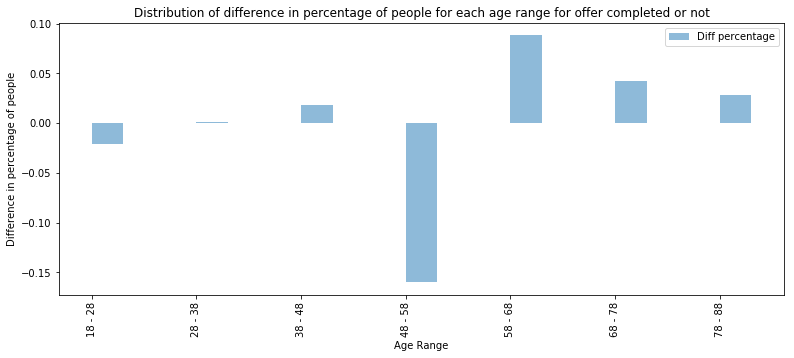

In [32]:
age_bin = ['18 - 28', '28 - 38', '38 - 48' , '48 - 58', '58 - 68' , '68 - 78', '78 - 88']
age_bin_pos = [i for i,_ in enumerate(age_bin)]

plt.figure(figsize = (13, 5))
plt.bar(age_bin, age_diff, alpha = 0.5, width = 0.3, align = 'edge', label = 'Diff percentage')
plt.xticks(age_bin_pos, age_bin, rotation='vertical')
plt.xlabel('Age Range')
plt.ylabel('Difference in percentage of people')
plt.title('Distribution of difference in percentage of people for each age range for offer completed or not')
plt.legend()
plt.show()

### Question 3: Income Distribution for Completion of BOGO and Discount Offer Types


In [33]:
id_bogo = []
id_discount = []
bogo = 'bogo'
discount = 'discount'

for id in tqdm(ids_present_both_completed):
    offer_id = transcript.loc[(transcript.person == id) & (transcript.event == 'offer completed')]['value']
    for offer in offer_id:
        offer_type_id = offer['offer_id']
        offer_type_str = str(portfolio[portfolio.id == offer_type_id]['offer_type'])
#         print(offer_type_str)
        offer_type_split = offer_type_str.split("\n")
#         print(offer_type_split[0])
#         print("HI")
        offer_type = offer_type_split[0][5:]
#         print(offer_type[5:] == bogo)
        if (offer_type == bogo) & ((id in id_bogo) == False):
            id_bogo.append(id)
        if (offer_type == 'discount') & ((id in id_discount) == False):
            id_discount.append(id)

# offer_type = portfolio.loc[portfolio.id == 'ae264e3637204a6fb9bb56bc8210ddfd']
# offer_type_str = str(offer_type['offer_type'])
# row = offer_type_str[0:1]
# offer_type_split = offer_type_str.split("\n")
# offer_type_split[0][5:] == 'bogo'
# str(offer_type['offer_type'])[5:]

100%|██████████| 12774/12774 [13:08<00:00, 14.54it/s]


In [34]:
len(id_bogo)

9263

In [35]:
len(id_discount)

10289

In [36]:
# Resource used to find this syntax: https://stackoverflow.com/questions/53342715/pandas-dataframe-select-rows-where-a-list-column-contains-any-of-a-list-of-strin
# This is creating a dataframe with only the id's that we're interested in
# (members who completed bogo and/or discount offers)
df_bogo = profile[pd.DataFrame(profile.id.tolist()).isin(id_bogo).any(1)]
df_discount = profile[pd.DataFrame(profile.id.tolist()).isin(id_discount).any(1)]

bogo_min_income = df_bogo['income'].min()
bogo_max_income = df_bogo['income'].max()

discount_min_income = df_discount['income'].min()
discount_max_income = df_discount['income'].max()

In [37]:
# np.arange resource used: https://realpython.com/how-to-use-numpy-arange/
# Create the distribution of incomes for members who completed bogo and/or discount 

df_bogo_distribution = df_bogo.groupby(pd.cut(df_bogo['income'], np.arange(start = bogo_min_income, stop = bogo_max_income, step = 7500)))['id'].count()
df_discount_distribution = df_discount.groupby(pd.cut(df_discount['income'], np.arange(start = discount_min_income, stop = discount_max_income, step = 7500)))['id'].count()


In [38]:
df_bogo_percentage = df_bogo_distribution/df_bogo_distribution.sum()
df_bogo_percentage

income
(30000.0, 37500.0]      0.073911
(37500.0, 45000.0]      0.074838
(45000.0, 52500.0]      0.092563
(52500.0, 60000.0]      0.139133
(60000.0, 67500.0]      0.113879
(67500.0, 75000.0]      0.158480
(75000.0, 82500.0]      0.089203
(82500.0, 90000.0]      0.096617
(90000.0, 97500.0]      0.077039
(97500.0, 105000.0]     0.052016
(105000.0, 112500.0]    0.032322
Name: id, dtype: float64

In [39]:
df_discount_percentage = df_discount_distribution/df_discount_distribution.sum()
df_discount_percentage

income
(30000.0, 37500.0]      0.082057
(37500.0, 45000.0]      0.087866
(45000.0, 52500.0]      0.096948
(52500.0, 60000.0]      0.139613
(60000.0, 67500.0]      0.115957
(67500.0, 75000.0]      0.152181
(75000.0, 82500.0]      0.087232
(82500.0, 90000.0]      0.089239
(90000.0, 97500.0]      0.068117
(97500.0, 105000.0]     0.049424
(105000.0, 112500.0]    0.031366
Name: id, dtype: float64

We can see that the bins that were created are the same for both bogo and discount, so we'll be using these bins as the bins for our histogram to show our distribution.

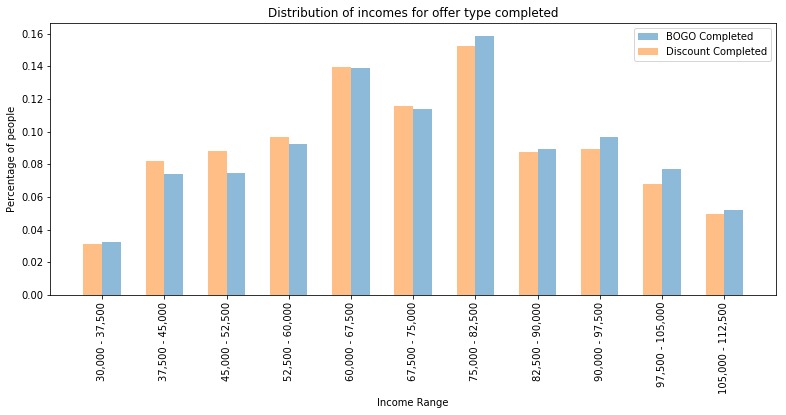

In [40]:
income_bin = ['30,000 - 37,500', '37,500 - 45,000', '45,000 - 52,500', '52,500 - 60,000', '60,000 - 67,500', 
         '67,500 - 75,000', '75,000 - 82,500', '82,500 - 90,000', '90,000 - 97,500', '97,500 - 105,000', '105,000 - 112,500']
income_bin_pos = [i for i,_ in enumerate(income_bin)]

plt.figure(figsize = (13, 5))
plt.bar(income_bin, df_bogo_percentage, alpha = 0.5, width = 0.3, align = 'edge', label = 'BOGO Completed')
plt.bar(income_bin, df_discount_percentage, alpha = 0.5, width = -0.3, align = 'edge', label = 'Discount Completed')
# plt.hist(df_bogo_distribution, income_bin, alpha = 0.5, label = 'BOGO Completed')
# plt.hist(df_discount_distribution, income_bin, alpha = 0.5, label = 'Discount Completed')
plt.xticks(income_bin_pos, income_bin, rotation='vertical')
plt.xlabel('Income Range')
plt.ylabel('Percentage of people')
plt.title('Distribution of incomes for offer type completed')
plt.legend()
plt.show()

In [41]:
income_diff = df_bogo_percentage - df_discount_percentage
income_diff

income
(30000.0, 37500.0]     -0.008146
(37500.0, 45000.0]     -0.013028
(45000.0, 52500.0]     -0.004385
(52500.0, 60000.0]     -0.000480
(60000.0, 67500.0]     -0.002079
(67500.0, 75000.0]      0.006299
(75000.0, 82500.0]      0.001971
(82500.0, 90000.0]      0.007379
(90000.0, 97500.0]      0.008922
(97500.0, 105000.0]     0.002591
(105000.0, 112500.0]    0.000956
Name: id, dtype: float64

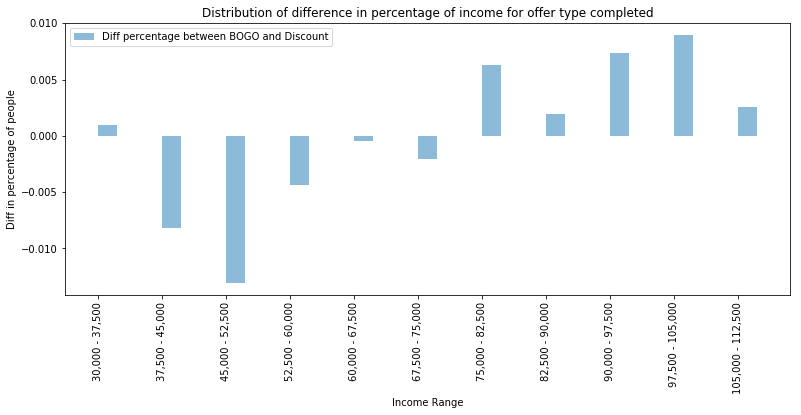

In [42]:
income_bin = ['30,000 - 37,500', '37,500 - 45,000', '45,000 - 52,500', '52,500 - 60,000', '60,000 - 67,500', 
         '67,500 - 75,000', '75,000 - 82,500', '82,500 - 90,000', '90,000 - 97,500', '97,500 - 105,000', '105,000 - 112,500']
income_bin_pos = [i for i,_ in enumerate(income_bin)]

plt.figure(figsize = (13, 5))
plt.bar(income_bin, income_diff, alpha = 0.5, width = 0.3, align = 'edge', label = 'Diff percentage between BOGO and Discount')
# plt.hist(df_bogo_distribution, income_bin, alpha = 0.5, label = 'BOGO Completed')
# plt.hist(df_discount_distribution, income_bin, alpha = 0.5, label = 'Discount Completed')
plt.xticks(income_bin_pos, income_bin, rotation='vertical')
plt.xlabel('Income Range')
plt.ylabel('Diff in percentage of people')
plt.title('Distribution of difference in percentage of income for offer type completed')
plt.legend()
plt.show()

### Conclusions
1. Based off of our visualizations, I can see that the most new members join in Autumn, followed by Winter and Summer, then finally Spring. A recommendation I may make towards offering members either BOGO or Discount offers would be target the Autumn and Winter seasons, especially as they have a lot of holidays, such as Halloween, Thanksgiving, and Christmas (even New Years if you would like to consider that as a holiday). With these holidays, I can potentially look to target the new members with offers to draw them in with the holiday themed drinks, as well as offers in order to maximize profit.

2. Next, I analyzed the average age of members who completed offers sent to them (regardless of the type of offer). I saw that the average age between the members who completed offers compared to the member who didn't complete offers wasn't that big of a difference. It was around 55 years old for the members who **completed** the offers, and around 53 years old for the members who **didn't complete** the offers. Thus, I decided to look into the distributions of the ages for the members who completed/didn't complete the offers. I looked for the biggest difference in percentage of people who completed and didn't complete the offers for each age range, so I could see which age range had the biggest difference. From the visualization, we could see that the age range of 58 - 68 and 68 - 78 were the 2 biggest positive differences, so a recommendation I can make would be potentially focusing on sending offers towards those 2 age ranges, as they had better relative percentages of members who did complete the offers. I would also recommend to maybe avoid sending as many offers to the 48 - 58 age range, as a significantly more percentage of members in that age range did not complete the offer.

3. Finally, I analyzed the distributions of the incomes of the members who completed a specific offer type (BOGO or Discount). For the **Discount** offers, the visualization shows that members with income range of 37,500 - 45,000 and 45,000 - 52,500 were more likely to complete the **Discount** offers, so I would recommend the **Discount** offers to be sent more frequently to these age ranges, which could increase profit. For the **BOGO** offers, the visualization shows that the income ranges 90,000 - 97,500 and 97,500 - 105,000 were more likely to complete them, so I would recommend to have these offers send more frequently to these age ranges.